###  VGG16 FC Layer 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

     |████████████████████████████████| 512.6MB 1.2MB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.60 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
     |████████████████████████████████| 753.4MB 20kB/s 
  Found existing installation: torch 0.4.1
    Uninstalling torch-0.4.1:
      Successfully uninstalled torch-0.4.1


In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [6]:
torch.__version__

'1.4.0'

In [0]:
data_dir = "./gdrive/My Drive/Assignment 5 Dataset"
data_dir_tr = "./gdrive/My Drive/Assign_5_Augm/train_aug"


### 2. Create PyTorch data generators

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir+'/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(data_dir+'/validation', data_transforms['validation'])
}
print(image_datasets['train'].class_to_idx)

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=64,
                                shuffle=True,num_workers=4),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=64,
                                shuffle=False,num_workers=4)
}
len(image_datasets['train'])
#len(image_datasets['validation'])

{'infected': 0, 'normal': 1}


12000

### 3. Create the network

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
model = models.vgg16(pretrained=True).to(device)
print(model)
num_features = model.classifier[0].in_features
for param in model.parameters():
  param.requires_grad=False
model.classifier=nn.Sequential( nn.Linear(num_features,160),
                               nn.Sigmoid(),
                               nn.Linear(160,2)).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [11]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(),lr=0.0001, momentum=0.9)

### 4. Train the model

In [0]:

def train_model(model, criterion, optimizer, num_epochs=3):
    loss_train=[]
    loss_val=[]
    acc_train=[]
    acc_val=[]
    Epochs=[]
    for epoch in range(num_epochs):
        print('Epoch ' ,epoch+1,'/',num_epochs)
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            i=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                i=i+1
                print('\r',i,end="")

                #print(i)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])
            if phase == 'train':
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            else:
                acc_val.append(epoch_acc)
                loss_val.append(epoch_loss)
                
            #Epochs,append(epoch_acc)

            print('  ','{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    
    A=plt.figure(1)
    #plt.plot(it,Loss,label='CE')
    plt.plot(range(num_epochs),acc_train,'r--',label='Training Accuracy')
    plt.plot(range(num_epochs),acc_val,'g--',label='Val Accuracy')
    #print(Loss)
    A.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    g = plt.figure(2)
    plt.plot(range(num_epochs),loss_train,'r--',label='Training Loss')
    plt.plot(range(num_epochs),loss_val,'g--',label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    g.legend()
    #g.savefig(('LOss'.png'),dpi=1200)        
    return model


In [14]:
len(image_datasets['train'])

12000

Epoch  1 / 30
----------
 188   train loss: 0.5734, acc: 0.7076
 24   validation loss: 0.4970, acc: 0.8120
Epoch  2 / 30
----------
 188   train loss: 0.4461, acc: 0.8544
 24   validation loss: 0.4289, acc: 0.8313
Epoch  3 / 30
----------
 188   train loss: 0.3916, acc: 0.8620
 24   validation loss: 0.4011, acc: 0.8340
Epoch  4 / 30
----------
 188   train loss: 0.3597, acc: 0.8669
 24   validation loss: 0.3833, acc: 0.8380
Epoch  5 / 30
----------
 188   train loss: 0.3423, acc: 0.8689
 24   validation loss: 0.3743, acc: 0.8387
Epoch  6 / 30
----------
 188   train loss: 0.3300, acc: 0.8731
 24   validation loss: 0.3654, acc: 0.8380
Epoch  7 / 30
----------
 188   train loss: 0.3217, acc: 0.8747
 24   validation loss: 0.3602, acc: 0.8420
Epoch  8 / 30
----------
 188   train loss: 0.3135, acc: 0.8788
 24   validation loss: 0.3552, acc: 0.8453
Epoch  9 / 30
----------
 188   train loss: 0.3067, acc: 0.8806
 24   validation loss: 0.3497, acc: 0.8447
Epoch  10 / 30
----------
 188   trai

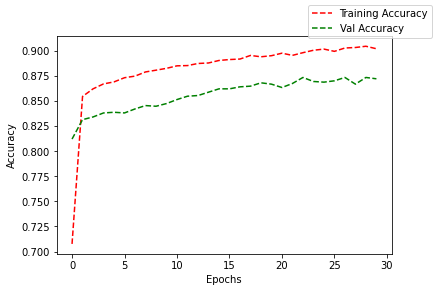

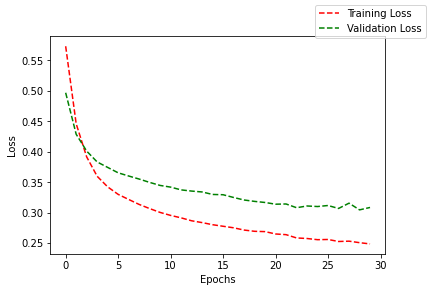

In [15]:
model_trained = train_model(model, criterion, optimizer, num_epochs=30)

### 5. Save and load the model

In [0]:
torch.save(model_trained.state_dict(), './gdrive/My Drive/Assign 5/vgg16_FC_Only.h5')

In [ ]:
model = models.vgg16(pretrained=True).to(device)
num_features = model.classifier[0].in_features
model.classifier=nn.Sequential( nn.Linear(num_features,160),
                               nn.Sigmoid(),
                               nn.Linear(160,2)).to(device)
model.load_state_dict(torch.load('./gdrive/My Drive/Assign 5/vgg16_FC_Only.h5'))
#model.eval()
print('testing')

### 6. Make predictions on sample test images

In [23]:
import torchvision
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, batch_size=9, shuffle=True)

class_names = test_data.classes
print(class_names)


['infected', 'normal']


In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


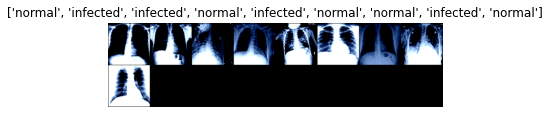

In [25]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [26]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal infected normal normal normal normal infected normal
Ground Truth:  normal infected infected normal infected normal normal infected normal


In [0]:
def Test_Result(testloader):
  correct = 0
  total = 0
  TN = 0
  FN=0
  TP=0
  FP=0
  print(device)
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          #print('\r', labels,end='')
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          gt=labels.to('cpu').numpy()
          est= predicted.to('cpu').numpy()
          #print(gt)
          for a in range(len(gt)):
            if gt[a]==0 and est[a]==0:
              TP+=1
            elif gt[a]==0 and est[a]==1:
              FP+=1
            elif gt[a]==1 and est[a]==0:
              FN+=1
            else :
              TN+=1
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))
  print('   True Positive ',TP,'   False Positive ',FP,'\n   True Negative ',TN,'   False Negative ',FN)
  print('F1 score : ',(2*TP)/(2*TP+FP+FN))

In [28]:
Test_Result(testloader)

cuda:0
Accuracy of the network: 93 %
   True Positive  531    False Positive  84 
   True Negative  868    False Negative  17
F1 score :  0.9145019052803484


In [29]:
Test_Result(dataloaders['validation'])

cuda:0
Accuracy of the network: 86 %
   True Positive  458    False Positive  157 
   True Negative  833    False Negative  52
F1 score :  0.8885333333333333


In [30]:
Test_Result(dataloaders['train'])

cuda:0
Accuracy of the network: 90 %
   True Positive  4087    False Positive  832 
   True Negative  6739    False Negative  342
F1 score :  0.874454666666


### 1. VGG16 With dropout

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

     |████████████████████████████████| 512.6MB 1.1MB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.60 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0


  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 0.4.1
    Uninstalling torch-0.4.1:
      Successfully uninstalled torch-0.4.1


In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torchvision

In [0]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [29]:
torch.__version__

'1.4.0'

In [0]:
data_dir = "./gdrive/My Drive/Assignment 5 Dataset"
data_dir_tr = "./gdrive/My Drive/Assign_5_Augm/train_aug"


### 2. Create PyTorch data generators

In [31]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir+'/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(data_dir+'/validation', data_transforms['validation'])
}
print(image_datasets['train'].class_to_idx)

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=64,
                                shuffle=True,num_workers=4),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=64,
                                shuffle=False,num_workers=4)
}
len(image_datasets['train'])
#len(image_datasets['validation'])

{'infected': 0, 'normal': 1}


12000

### 3. Create the network

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
model = models.vgg16(pretrained=True).to(device)
print(model)
num_features = model.classifier[0].in_features
for param in model.parameters():
  param.requires_grad=False
model.classifier=nn.Sequential( nn.Linear(num_features,160),
                               nn.Sigmoid(),
                               nn.Dropout(p=0.4, inplace=False),
                               nn.Linear(160,2)).to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(),lr=0.0001, momentum=0.9)

### 4. Train the model

In [0]:

def train_model(model, criterion, optimizer, num_epochs=3):
    loss_train=[]
    loss_val=[]
    acc_train=[]
    acc_val=[]
    Epochs=[]
    for epoch in range(num_epochs):
        print('Epoch ' ,epoch+1,'/',num_epochs)
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            i=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                i=i+1
                print('\r',i,end="")

                #print(i)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])
            if phase == 'train':
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            else:
                acc_val.append(epoch_acc)
                loss_val.append(epoch_loss)
                
            #Epochs,append(epoch_acc)

            print('  ','{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    
    A=plt.figure(1)
    #plt.plot(it,Loss,label='CE')
    plt.plot(range(num_epochs),acc_train,'r--',label='Training Accuracy')
    plt.plot(range(num_epochs),acc_val,'g--',label='Val Accuracy')
    #print(Loss)
    A.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    g = plt.figure(2)
    plt.plot(range(num_epochs),loss_train,'r--',label='Training Loss')
    plt.plot(range(num_epochs),loss_val,'g--',label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    g.legend()
    #g.savefig(('LOss'.png'),dpi=1200)        
    return model


In [37]:
len(image_datasets['train'])

12000

Epoch  1 / 30
----------
 188   train loss: 0.5996, acc: 0.6864
 24   validation loss: 0.5166, acc: 0.7947
Epoch  2 / 30
----------
 188   train loss: 0.4782, acc: 0.8195
 24   validation loss: 0.4452, acc: 0.8267
Epoch  3 / 30
----------
 188   train loss: 0.4209, acc: 0.8471
 24   validation loss: 0.4118, acc: 0.8327
Epoch  4 / 30
----------
 188   train loss: 0.3860, acc: 0.8549
 24   validation loss: 0.3938, acc: 0.8333
Epoch  5 / 30
----------
 188   train loss: 0.3639, acc: 0.8612
 24   validation loss: 0.3809, acc: 0.8320
Epoch  6 / 30
----------
 188   train loss: 0.3515, acc: 0.8652
 24   validation loss: 0.3735, acc: 0.8387
Epoch  7 / 30
----------
 188   train loss: 0.3412, acc: 0.8652
 24   validation loss: 0.3669, acc: 0.8373
Epoch  8 / 30
----------
 188   train loss: 0.3314, acc: 0.8706
 24   validation loss: 0.3625, acc: 0.8427
Epoch  9 / 30
----------
 188   train loss: 0.3238, acc: 0.8708
 24   validation loss: 0.3578, acc: 0.8440
Epoch  10 / 30
----------
 188   trai

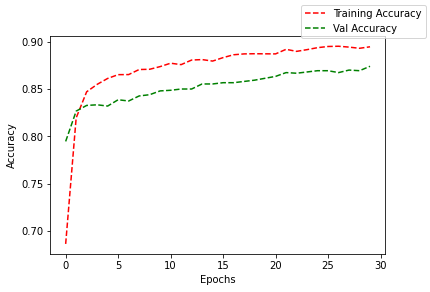

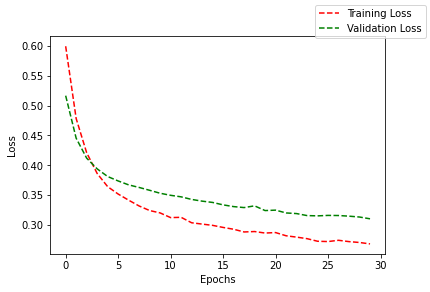

In [38]:
model_trained = train_model(model, criterion, optimizer, num_epochs=30)

### 5. Save and load the model

In [0]:
torch.save(model_trained.state_dict(), './gdrive/My Drive/Assign 5/vgg16_FC_Only_drop.h5')

In [51]:

model = models.vgg16(pretrained=True).to(device)
num_features = model.classifier[0].in_features
model.classifier=nn.Sequential( nn.Linear(num_features,160),
                               nn.Sigmoid(),
                               nn.Dropout(p=0.2, inplace=False),
                               nn.Linear(160,2)).to(device)
model.load_state_dict(torch.load('./gdrive/My Drive/Assign 5/vgg16_FC_Only_drop.h5'))
model.eval()
print('testing')


testing


### 6. Make predictions on sample test images

In [41]:

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, batch_size=9, shuffle=True)

class_names = test_data.classes
print(class_names)


['infected', 'normal']


In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


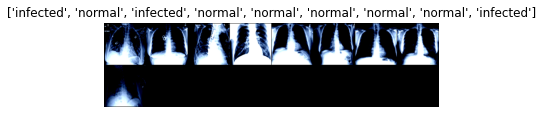

In [43]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [44]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal infected normal normal normal normal normal infected
Ground Truth:  infected normal infected normal normal normal normal normal infected


In [0]:
def Test_Result(testloader):
  correct = 0
  total = 0
  TN = 0
  FN=0
  TP=0
  FP=0
  print(device)
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          #print('\r', labels,end='')
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          gt=labels.to('cpu').numpy()
          est= predicted.to('cpu').numpy()
          #print(gt)
          for a in range(len(gt)):
            if gt[a]==0 and est[a]==0:
              TP+=1
            elif gt[a]==0 and est[a]==1:
              FP+=1
            elif gt[a]==1 and est[a]==0:
              FN+=1
            else :
              TN+=1
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))
  print('   True Positive ',TP,'   False Positive ',FP,'\n   True Negative ',TN,'   False Negative ',FN)
  print('F1 score : ',(2*TP)/(2*TP+FP+FN))

In [46]:
Test_Result(testloader)

cuda:0
Accuracy of the network: 93 %
   True Positive  545    False Positive  70 
   True Negative  864    False Negative  21
F1 score :  0.9229725456666


In [47]:
Test_Result(dataloaders['validation'])

cuda:0
Accuracy of the network: 87 %
   True Positive  493    False Positive  122 
   True Negative  818    False Negative  67
F1 score :  0.839146446467777


In [48]:
Test_Result(dataloaders['train'])

cuda:0
Accuracy of the network: 90 %
   True Positive  4216    False Positive  704 
   True Negative  6585    False Negative  496
F1 score :  0.87546477777899999


### Resnet18

In [1]:
from google.colab import drive
drive.mount('./gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [0]:
#!unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip" -d "./gdrive/My Drive"

In [2]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-1.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [5]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [6]:
torch.__version__

'1.4.0'

In [0]:
data_dir_tr = "./gdrive/My Drive/Assign_5_Augm/train_aug"
data_dir_vl = "./gdrive/My Drive/Assignment 5 Dataset"

### 2. Create PyTorch data generators

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir_vl+'/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(data_dir_vl+'/validation', data_transforms['validation'])
}
print(image_datasets['train'].class_to_idx)

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=64,
                                shuffle=True,num_workers=4),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=64,
                                shuffle=False,num_workers=4)
}
len(image_datasets['train'])
#len(image_datasets['validation'])

{'infected': 0, 'normal': 1}


12000

### 3. Create the network

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
model = models.resnet18(pretrained=True).to(device)
print(model)
num_features = model.fc.in_features
for param in model.parameters():
  param.requires_grad=False
model.fc=nn.Sequential( nn.Linear(num_features,160),
                               nn.Sigmoid(),
                                nn.Dropout(p=0.1,inplace=False),
                               nn.Linear(160,2)).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [12]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(),lr=0.001, momentum=0.9)

### 4. Train the model

In [0]:

def train_model(model, criterion, optimizer, num_epochs=3):
    loss_train=[]
    loss_val=[]
    acc_train=[]
    acc_val=[]
    Epochs=[]
    for epoch in range(num_epochs):
        print('Epoch ' ,epoch+1,'/',num_epochs)
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            i=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                i=i+1
                print('\r',i,end="")

                #print(i)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])
            if phase == 'train':
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            else:
                acc_val.append(epoch_acc)
                loss_val.append(epoch_loss)
                
            #Epochs,append(epoch_acc)

            print('  ','{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    
    A=plt.figure(1)
    #plt.plot(it,Loss,label='CE')
    plt.plot(range(num_epochs),acc_train,'r--',label='Training Accuracy')
    plt.plot(range(num_epochs),acc_val,'g--',label='Val Accuracy')
    #print(Loss)
    A.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    g = plt.figure(2)
    plt.plot(range(num_epochs),loss_train,'r--',label='Training Loss')
    plt.plot(range(num_epochs),loss_val,'g--',label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    g.legend()
    #g.savefig(('LOss'.png'),dpi=1200)        
    return model


In [0]:
len(image_datasets['train'])

12000

[link text](https://)

Epoch  1 / 30
----------
 188   train loss: 0.6722, acc: 0.5836
 24   validation loss: 0.6644, acc: 0.5900
Epoch  2 / 30
----------
 188   train loss: 0.6520, acc: 0.5966
 24   validation loss: 0.6433, acc: 0.5913
Epoch  3 / 30
----------
 188   train loss: 0.6283, acc: 0.6637
 24   validation loss: 0.6177, acc: 0.6967
Epoch  4 / 30
----------
 188   train loss: 0.5993, acc: 0.7631
 24   validation loss: 0.5887, acc: 0.7873
Epoch  5 / 30
----------
 188   train loss: 0.5709, acc: 0.8072
 24   validation loss: 0.5644, acc: 0.7920
Epoch  6 / 30
----------
 188   train loss: 0.5486, acc: 0.8129
 24   validation loss: 0.5451, acc: 0.8027
Epoch  7 / 30
----------
 188   train loss: 0.5311, acc: 0.8224
 24   validation loss: 0.5308, acc: 0.8087
Epoch  8 / 30
----------
 188   train loss: 0.5178, acc: 0.8292
 24   validation loss: 0.5201, acc: 0.8100
Epoch  9 / 30
----------
 188   train loss: 0.5079, acc: 0.8283
 24   validation loss: 0.5132, acc: 0.8133
Epoch  10 / 30
----------
 188   trai

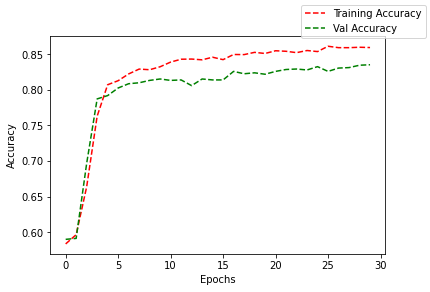

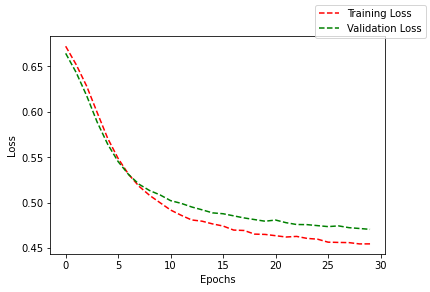

In [0]:
model_trained = train_model(model, criterion, optimizer, num_epochs=30)

### 5. Save and load the model

In [0]:
torch.save(model_trained.state_dict(), './gdrive/My Drive/Assign 5/res18_FC_Only.h5')

In [15]:
model = models.resnet18(pretrained=True).to(device)
model.fc=nn.Sequential( nn.Linear(num_features,160),
                               nn.Sigmoid(),
                                nn.Dropout(p=0.1,inplace=False),
                               nn.Linear(160,2)).to(device)
model.load_state_dict(torch.load('./gdrive/My Drive/Assign 5/res18_FC_Only.h5'))
model.eval()
print('testing')

testing


### 6. Make predictions on sample test images

In [17]:
import torchvision
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_data = datasets.ImageFolder(data_dir_vl + '/test', transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, batch_size=9, shuffle=True)

class_names = test_data.classes
print(class_names)


['infected', 'normal']


In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


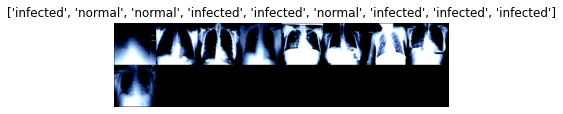

In [19]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [20]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal normal normal infected normal normal normal infected
Ground Truth:  infected normal normal infected infected normal infected infected infected


In [0]:
def Test_Result(testloader):
  correct = 0
  total = 0
  TN = 0
  FN=0
  TP=0
  FP=0
  print(device)
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          #print('\r', labels,end='')
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          gt=labels.to('cpu').numpy()
          est= predicted.to('cpu').numpy()
          #print(gt)
          for a in range(len(gt)):
            if gt[a]==0 and est[a]==0:
              TP+=1
            elif gt[a]==0 and est[a]==1:
              FP+=1
            elif gt[a]==1 and est[a]==0:
              FN+=1
            else :
              TN+=1
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))
  print('   True Positive ',TP,'   False Positive ',FP,'\n   True Negative ',TN,'   False Negative ',FN)
  print('F1 score : ',(2*TP)/(2*TP+FP+FN))

In [26]:
Test_Result(testloader)

cuda:0
Accuracy of the network: 91 %
   True Positive  522    False Positive  93 
   True Negative  843    False Negative  42
F1 score :  0.8854961832061069


In [27]:
Test_Result(dataloaders['validation'])

cuda:0
Accuracy of the network: 83 %
   True Positive  465    False Positive  150 
   True Negative  788    False Negative  97
F1 score :  0.7901444350042481


In [28]:
Test_Result(dataloaders['train'])

cuda:0
Accuracy of the network: 86 %
   True Positive  3884    False Positive  1035 
   True Negative  6452    False Negative  629
F1 score :  0.823579304495335


### ResNet Single Conv+ FC layer

In [27]:
from google.colab import drive
drive.mount('./gdrive')


Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


In [0]:
#!unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip" -d "./gdrive/My Drive"

In [3]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-1.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [0]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [0]:
torch.__version__

'1.4.0'

In [0]:
data_dir_tr = "./gdrive/My Drive/Assign_5_Augm/train_aug"
data_dir_vl = "./gdrive/My Drive/Assignment 5 Dataset"

### 2. Create PyTorch data generators

In [20]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir_vl+'/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(data_dir_vl+'/validation', data_transforms['validation'])
}
print(image_datasets['train'].class_to_idx)

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=128,
                                shuffle=True,num_workers=4),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=128,
                                shuffle=False,num_workers=4)
}
len(image_datasets['train'])
#len(image_datasets['validation'])

{'infected': 0, 'normal': 1}


12000

### 3. Create the network

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
model = models.resnet18(pretrained=True).to(device)
#print(model)
print(model.layer4[1].conv2)
num_features = model.fc.in_features
for param in model.parameters():
  param.requires_grad=False
for param in model.layer4[1].conv2.parameters():
  param.requires_grad=True

model.fc=nn.Sequential( nn.Linear(num_features,160),
                               nn.Sigmoid(),
                                nn.Dropout(p=0.5,inplace=False),
                               nn.Linear(160,2)).to(device)


Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [17]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.fc.parameters(),lr=0.001, momentum=0.9)
for param in filter(lambda p: p.requires_grad, model.parameters()):
  print(param.requires_grad)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

True
True
True
True
True


### 4. Train the model

In [0]:

def train_model(model, criterion, optimizer, num_epochs=3):
    loss_train=[]
    loss_val=[]
    acc_train=[]
    acc_val=[]
    Epochs=[]
    for epoch in range(num_epochs):
        print('Epoch ' ,epoch+1,'/',num_epochs)
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            i=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                i=i+1
                print('\r',i,end="")

                #print(i)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])
            if phase == 'train':
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            else:
                acc_val.append(epoch_acc)
                loss_val.append(epoch_loss)
                
            #Epochs,append(epoch_acc)

            print('  ','{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    
    A=plt.figure(1)
    #plt.plot(it,Loss,label='CE')
    plt.plot(range(num_epochs),acc_train,'r--',label='Training Accuracy')
    plt.plot(range(num_epochs),acc_val,'g--',label='Val Accuracy')
    #print(Loss)
    A.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    g = plt.figure(2)
    plt.plot(range(num_epochs),loss_train,'r--',label='Training Loss')
    plt.plot(range(num_epochs),loss_val,'g--',label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    g.legend()
    #g.savefig(('LOss'.png'),dpi=1200)        
    return model


In [0]:
len(image_datasets['train'])

12000

[link text](https://)

Epoch  1 / 15
----------
 94   train loss: 0.3373, acc: 0.8574
 12   validation loss: 0.3327, acc: 0.8620
Epoch  2 / 15
----------
 94   train loss: 0.2733, acc: 0.8908
 12   validation loss: 0.3332, acc: 0.8680
Epoch  3 / 15
----------
 94   train loss: 0.2691, acc: 0.8931
 12   validation loss: 0.3262, acc: 0.8620
Epoch  4 / 15
----------
 94   train loss: 0.2610, acc: 0.8951
 12   validation loss: 0.3264, acc: 0.8647
Epoch  5 / 15
----------
 94   train loss: 0.2566, acc: 0.8952
 12   validation loss: 0.3150, acc: 0.8640
Epoch  6 / 15
----------
 94   train loss: 0.2520, acc: 0.9025
 12   validation loss: 0.3147, acc: 0.8647
Epoch  7 / 15
----------
 94   train loss: 0.2505, acc: 0.9000
 12   validation loss: 0.3393, acc: 0.8700
Epoch  8 / 15
----------
 94   train loss: 0.2520, acc: 0.8982
 12   validation loss: 0.3134, acc: 0.8667
Epoch  9 / 15
----------
 94   train loss: 0.2451, acc: 0.9020
 12   validation loss: 0.3263, acc: 0.8627
Epoch  10 / 15
----------
 94   train loss: 0.

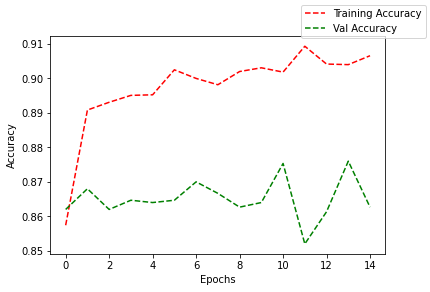

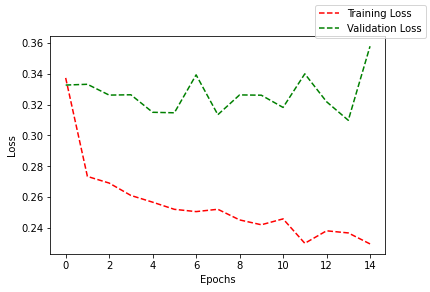

In [21]:
model_trained = train_model(model, criterion, optimizer, num_epochs=15)

### 5. Save and load the model

In [0]:
torch.save(model_trained.state_dict(), './gdrive/My Drive/Assign 5/Resnet_single_conv_Task2.h5')

In [30]:
model = models.resnet18(pretrained=True).to(device)
model.fc=nn.Sequential( nn.Linear(num_features,160),
                               nn.Sigmoid(),
                                nn.Dropout(p=0.1,inplace=False),
                               nn.Linear(160,2)).to(device)
model.load_state_dict(torch.load('./gdrive/My Drive/Assign 5/Resnet_single_conv_Task2.h5'))
model.eval()
print('testing')

testing


### 6. Make predictions on sample test images

In [32]:

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_data = datasets.ImageFolder(data_dir_vl + '/test', transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, batch_size=9, shuffle=True)

class_names = test_data.classes
print(class_names)


['infected', 'normal']


In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


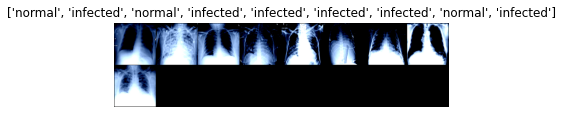

In [34]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [35]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected normal infected infected infected infected normal infected
Ground Truth:  normal infected normal infected infected infected infected normal infected


In [0]:
def Test_Result(testloader):
  correct = 0
  total = 0
  TN = 0
  FN=0
  TP=0
  FP=0
  print(device)
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          #print('\r', labels,end='')
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          gt=labels.to('cpu').numpy()
          est= predicted.to('cpu').numpy()
          #print(gt)
          for a in range(len(gt)):
            if gt[a]==0 and est[a]==0:
              TP+=1
            elif gt[a]==0 and est[a]==1:
              FP+=1
            elif gt[a]==1 and est[a]==0:
              FN+=1
            else :
              TN+=1
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))
  print('   True Positive ',TP,'   False Positive ',FP,'\n   True Negative ',TN,'   False Negative ',FN)
  print('F1 score : ',(2*TP)/(2*TP+FP+FN))

In [37]:
Test_Result(testloader)

cuda:0
Accuracy of the network: 92 %
   True Positive  584    False Positive  31 
   True Negative  803    False Negative  82
F1 score :  0.9117876658860266


In [38]:
Test_Result(dataloaders['validation'])

cuda:0
Accuracy of the network: 86 %
   True Positive  557    False Positive  58 
   True Negative  737    False Negative  148
F1 score :  0.843939393939394


In [39]:
Test_Result(dataloaders['train'])

cuda:0
Accuracy of the network: 89 %
   True Positive  4561    False Positive  358 
   True Negative  6180    False Negative  901
F1 score :  0.8787207398131202


### 1. VGG16 Single Conv+ FC layer

In [1]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [0]:
#!unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip" -d "./gdrive/My Drive"

In [2]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

     |████████████████████████████████| 512.6MB 1.1MB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.60 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
     |████████████████████████████████| 753.4MB 22kB/s 
  Found existing installation: torch 0.4.1
    Uninstalling torch-0.4.1:
      Successfully uninstalled torch-0.4.1


In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [0]:
torch.__version__

'1.4.0'

In [0]:
data_dir = "./gdrive/My Drive/Assignment 5 Dataset"
data_dir_tr = "./gdrive/My Drive/Assign_5_Augm/train_aug"


### 2. Create PyTorch data generators

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir+'/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(data_dir+'/validation', data_transforms['validation'])
}
print(image_datasets['train'].class_to_idx)

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=64,
                                shuffle=True,num_workers=4),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=64,
                                shuffle=False,num_workers=4)
}
len(image_datasets['train'])
#len(image_datasets['validation'])

{'infected': 0, 'normal': 1}


12000

### 3. Create the network

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
model = models.vgg16(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
num_features = model.classifier[0].in_features
for param in model.features.parameters():
  param.requires_grad=False
for param in model.features[28].parameters():
  param.requires_grad=True
model.classifier=nn.Sequential( nn.Linear(num_features,160),
                                nn.Sigmoid(),
                               nn.Linear(160,2)).to(device)
#print(model)
#total_params = sum(p.numel() for p in model.parameters())
#print(total_params)
for param in model.parameters():
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [0]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.fc.parameters(),lr=0.001, momentum=0.9)
for param in filter(lambda p: p.requires_grad, model.parameters()):
  print(param.requires_grad)
optimizer = optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=0.001)

True
True
True
True
True
True


### 4. Train the model

In [0]:

def train_model(model, criterion, optimizer, num_epochs=3):
    loss_train=[]
    loss_val=[]
    acc_train=[]
    acc_val=[]
    Epochs=[]
    for epoch in range(num_epochs):
        print('Epoch ' ,epoch+1,'/',num_epochs)
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            i=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                i=i+1
                print('\r',i,end="")

                #print(i)
                #print(i)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])
            if phase == 'train':
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            else:
                acc_val.append(epoch_acc)
                loss_val.append(epoch_loss)
                
            #Epochs,append(epoch_acc)

            print('  ','{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    
    A=plt.figure(1)
    #plt.plot(it,Loss,label='CE')
    plt.plot(range(num_epochs),acc_train,'r--',label='Training Accuracy')
    plt.plot(range(num_epochs),acc_val,'g--',label='Val Accuracy')
    #print(Loss)
    A.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    g = plt.figure(2)
    plt.plot(range(num_epochs),loss_train,'r--',label='Training Loss')
    plt.plot(range(num_epochs),loss_val,'g--',label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    g.legend()
    #g.savefig(('LOss'.png'),dpi=1200)        
    return model


In [0]:
len(image_datasets['train'])

12000

Epoch  1 / 30
----------
Epoch  1 / 30
----------
 188   train loss: 0.2933, acc: 0.8850
   train loss: 0.2933, acc: 0.8850
 24   validation loss: 0.3363, acc: 0.8553
Epoch  2 / 30
----------
   validation loss: 0.3363, acc: 0.8553
Epoch  2 / 30
----------
 188   train loss: 0.2095, acc: 0.9230
   train loss: 0.2095, acc: 0.9230
 24   validation loss: 0.2496, acc: 0.9013
Epoch  3 / 30
----------
   validation loss: 0.2496, acc: 0.9013
Epoch  3 / 30
----------
 188   train loss: 0.1982, acc: 0.9246
   train loss: 0.1982, acc: 0.9246
 24   validation loss: 0.2472, acc: 0.9067
Epoch  4 / 30
----------
   validation loss: 0.2472, acc: 0.9067
Epoch  4 / 30
----------
 188   train loss: 0.1852, acc: 0.9322
   train loss: 0.1852, acc: 0.9322
 24   validation loss: 0.2523, acc: 0.8980
Epoch  5 / 30
----------
   validation loss: 0.2523, acc: 0.8980
Epoch  5 / 30
----------
 188   train loss: 0.1776, acc: 0.9353
   train loss: 0.1776, acc: 0.9353
 24   validation loss: 0.2430, acc: 0.9080
Epoch

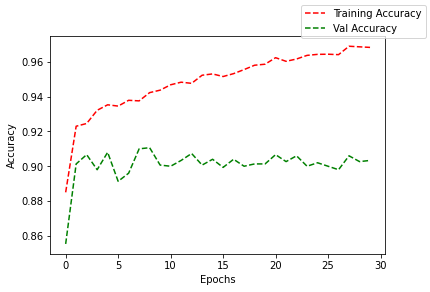

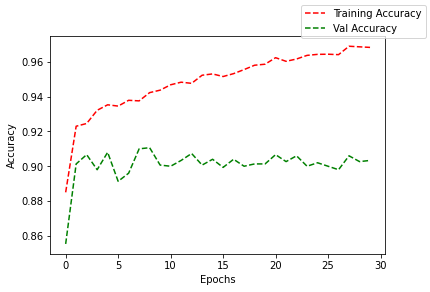

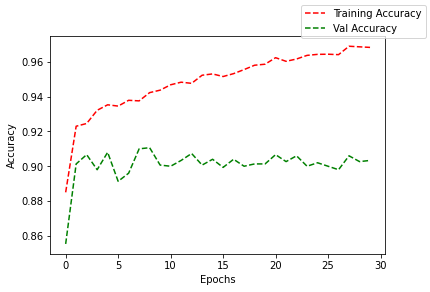

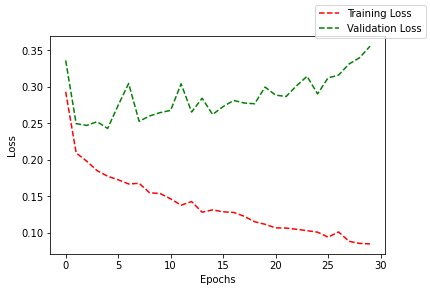

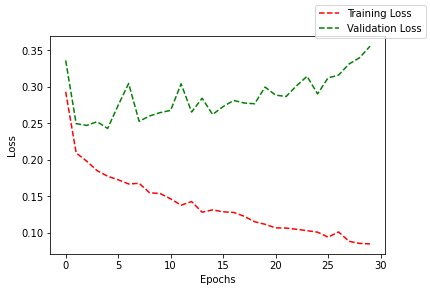

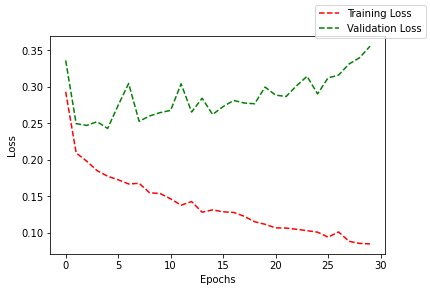

In [0]:
model_trained = train_model(model, criterion, optimizer, num_epochs=30) # Multiple graph are due to server reconnecting and doing such odd things

### 5. Save and load the model

In [0]:
torch.save(model_trained.state_dict(), './gdrive/My Drive/Assign 5/VGG16_single_conv_Task2.ipynb.h5')

In [8]:
model = models.vgg16(pretrained=True).to(device)
num_features = model.classifier[0].in_features
model.classifier=nn.Sequential( nn.Linear(num_features,160),
                                nn.Sigmoid(),
                               nn.Linear(160,2)).to(device)
model.load_state_dict(torch.load('./gdrive/My Drive/Assign 5/VGG16_single_conv_Task2.ipynb.h5'))
print('testing')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



testing


### 6. Make predictions on sample test images

In [9]:
import torchvision 
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, batch_size=9, shuffle=True)

class_names = test_data.classes
print(class_names)


['infected', 'normal']


In [10]:
len(test_data)

1500

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


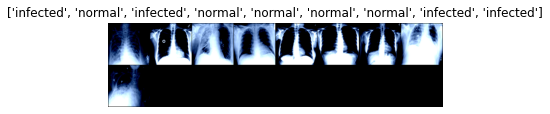

In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [15]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal infected normal normal normal normal infected infected
Ground Truth:  infected normal infected normal normal normal normal infected infected


In [0]:
def Test_Result(testloader):
  correct = 0
  total = 0
  TN = 0
  FN=0
  TP=0
  FP=0
  print(device)
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          #print('\r', labels,end='')
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          gt=labels.to('cpu').numpy()
          est= predicted.to('cpu').numpy()
          #print(gt)
          for a in range(len(gt)):
            if gt[a]==0 and est[a]==0:
              TP+=1
            elif gt[a]==0 and est[a]==1:
              FP+=1
            elif gt[a]==1 and est[a]==0:
              FN+=1
            else :
              TN+=1
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))
  print('   True Positive ',TP,'   False Positive ',FP,'\n   True Negative ',TN,'   False Negative ',FN)
  print('F1 score : ',(2*TP)/(2*TP+FP+FN))

In [17]:
Test_Result(testloader)


cuda:0
Accuracy of the network: 95 %
   True Positive  581    False Positive  34 
   True Negative  857    False Negative  28
F1 score :  0.9493464052287581


In [18]:
Test_Result(dataloaders['validation'])

cuda:0
Accuracy of the network: 90 %
   True Positive  550    False Positive  65 
   True Negative  805    False Negative  80
F1 score :  0.8835341365461847


In [19]:
Test_Result(dataloaders['train'])

cuda:0
Accuracy of the network: 97 %
   True Positive  4724    False Positive  195 
   True Negative  6924    False Negative  157
F1 score :  0.9640816326530612


### ResNet18 Mulltiple Conv + FC layers

In [0]:
from google.colab import drive
drive.mount('./gdrive')


Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


In [0]:
#!unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip" -d "./gdrive/My Drive"

In [0]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-1.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [0]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [0]:
torch.__version__

'1.4.0'

In [0]:
data_dir_tr = "./gdrive/My Drive/Assign_5_Augm/train_aug"
data_dir_vl = "./gdrive/My Drive/Assignment 5 Dataset"

### 2. Create PyTorch data generators

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir_vl+'/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(data_dir_vl+'/validation', data_transforms['validation'])
}
print(image_datasets['train'].class_to_idx)

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=128,
                                shuffle=True,num_workers=4),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=128,
                                shuffle=False,num_workers=4)
}
len(image_datasets['train'])
#len(image_datasets['validation'])

{'infected': 0, 'normal': 1}


12000

### 3. Create the network

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
model = models.resnet18(pretrained=True).to(device)
print(model)
num_features = model.fc.in_features
for param in model.parameters():
  param.requires_grad=False
for param in model.layer4.parameters():
  param.requires_grad=True

model.fc=nn.Sequential( nn.Linear(num_features,160),
                               nn.Sigmoid(),
                                nn.Dropout(p=0.5,inplace=False),
                               nn.Linear(160,2)).to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.fc.parameters(),lr=0.001, momentum=0.9)
for param in filter(lambda p: p.requires_grad, model.parameters()):
  print(param.requires_grad)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


### 4. Train the model

In [0]:

def train_model(model, criterion, optimizer, num_epochs=3):
    loss_train=[]
    loss_val=[]
    acc_train=[]
    acc_val=[]
    Epochs=[]
    for epoch in range(num_epochs):
        print('Epoch ' ,epoch+1,'/',num_epochs)
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            i=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                i=i+1
                print('\r',i,end="")

                #print(i)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])
            if phase == 'train':
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            else:
                acc_val.append(epoch_acc)
                loss_val.append(epoch_loss)
                
            #Epochs,append(epoch_acc)

            print('  ','{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    
    A=plt.figure(1)
    #plt.plot(it,Loss,label='CE')
    plt.plot(range(num_epochs),acc_train,'r--',label='Training Accuracy')
    plt.plot(range(num_epochs),acc_val,'g--',label='Val Accuracy')
    #print(Loss)
    A.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    g = plt.figure(2)
    plt.plot(range(num_epochs),loss_train,'r--',label='Training Loss')
    plt.plot(range(num_epochs),loss_val,'g--',label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    g.legend()
    #g.savefig(('LOss'.png'),dpi=1200)        
    return model


In [0]:
len(image_datasets['train'])

12000

[link text](https://)

Epoch  1 / 15
----------
 94   train loss: 0.2425, acc: 0.9053
 12   validation loss: 0.2852, acc: 0.8847
Epoch  2 / 15
----------
 94   train loss: 0.2065, acc: 0.9228
 12   validation loss: 0.2325, acc: 0.9073
Epoch  3 / 15
----------
 94   train loss: 0.1814, acc: 0.9319
 12   validation loss: 0.2255, acc: 0.9087
Epoch  4 / 15
----------
 94   train loss: 0.1722, acc: 0.9353
 12   validation loss: 0.2109, acc: 0.9153
Epoch  5 / 15
----------
 94   train loss: 0.1645, acc: 0.9387
 12   validation loss: 0.2278, acc: 0.9073
Epoch  6 / 15
----------
 94   train loss: 0.1536, acc: 0.9439
 12   validation loss: 0.2290, acc: 0.9093
Epoch  7 / 15
----------
 94   train loss: 0.1521, acc: 0.9433
 12   validation loss: 0.2626, acc: 0.9047
Epoch  8 / 15
----------
 94   train loss: 0.1437, acc: 0.9427
 12   validation loss: 0.2293, acc: 0.9113
Epoch  9 / 15
----------
 94   train loss: 0.1341, acc: 0.9501
 12   validation loss: 0.2330, acc: 0.9107
Epoch  10 / 15
----------
 94   train loss: 0.

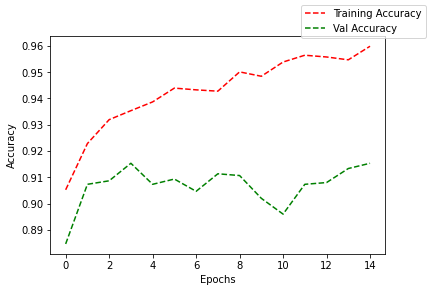

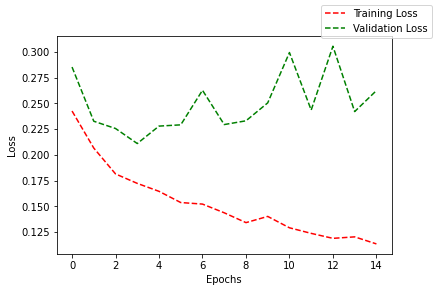

In [32]:
model_trained = train_model(model, criterion, optimizer, num_epochs=15)

### 5. Save and load the model

In [0]:
torch.save(model_trained.state_dict(), './gdrive/My Drive/Assign 5/Resnet_multiple_task2.h5')

In [51]:
model = models.resnet18(pretrained=True).to(device)
num_features = model.fc.in_features

model.fc=nn.Sequential( nn.Linear(num_features,160),
                               nn.Sigmoid(),
                                nn.Dropout(p=0.5,inplace=False),
                               nn.Linear(160,2)).to(device)
model.load_state_dict(torch.load('./gdrive/My Drive/Assign 5/Resnet_multiple_task2.h5'))
model.eval()
print('testing')

testing


### 6. Make predictions on sample test images

In [52]:

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_data = datasets.ImageFolder(data_dir_vl + '/test', transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, batch_size=9, shuffle=True)

class_names = test_data.classes
print(class_names)


['infected', 'normal']


In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


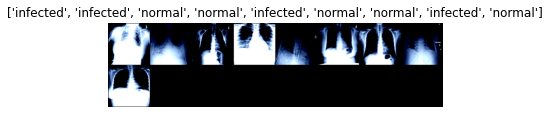

In [54]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [55]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal normal infected normal normal infected normal
Ground Truth:  infected infected normal normal infected normal normal infected normal


In [0]:
def Test_Result(testloader):
  correct = 0
  total = 0
  TN = 0
  FN=0
  TP=0
  FP=0
  print(device)
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          #print('\r', labels,end='')
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          gt=labels.to('cpu').numpy()
          est= predicted.to('cpu').numpy()
          #print(gt)
          for a in range(len(gt)):
            if gt[a]==0 and est[a]==0:
              TP+=1
            elif gt[a]==0 and est[a]==1:
              FP+=1
            elif gt[a]==1 and est[a]==0:
              FN+=1
            else :
              TN+=1
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))
  print('   True Positive ',TP,'   False Positive ',FP,'\n   True Negative ',TN,'   False Negative ',FN)
  print('F1 score : ',(2*TP)/(2*TP+FP+FN))

In [57]:
Test_Result(testloader)

cuda:0
Accuracy of the network: 97 %
   True Positive  588    False Positive  27 
   True Negative  868    False Negative  17
F1 score :  0.9639344262295082


In [58]:
Test_Result(dataloaders['validation'])

cuda:0
Accuracy of the network: 91 %
   True Positive  549    False Positive  66 
   True Negative  824    False Negative  61
F1 score :  0.8963265306122449


In [59]:
Test_Result(dataloaders['train'])

cuda:0
Accuracy of the network: 96 %
   True Positive  4607    False Positive  312 
   True Negative  6980    False Negative  101
F1 score :  0.9570998234133167


### Vgg16 multiple Conv + FC layers

In [0]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [0]:
#!unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip" -d "./gdrive/My Drive"

In [0]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

     |████████████████████████████████| 512.6MB 1.4MB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.60 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
     |████████████████████████████████| 753.4MB 22kB/s 
  Found existing installation: torch 0.4.1
    Uninstalling torch-0.4.1:
      Successfully uninstalled torch-0.4.1


In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [0]:
torch.__version__

'1.4.0'

In [0]:
data_dir = "./gdrive/My Drive/Assignment 5 Dataset"
data_dir_tr = "./gdrive/My Drive/Assign_5_Augm/train_aug"


### 2. Create PyTorch data generators

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir+'/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(data_dir+'/validation', data_transforms['validation'])
}
print(image_datasets['train'].class_to_idx)

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=64,
                                shuffle=True,num_workers=4),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=64,
                                shuffle=False,num_workers=4)
}
len(image_datasets['train'])
#len(image_datasets['validation'])

{'infected': 0, 'normal': 1}


12000

### 3. Create the network

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
model = models.vgg16(pretrained=True).to(device)

In [0]:
num_features = model.classifier[0].in_features
for param in model.features.parameters():
  param.requires_grad=False
for param in model.features[20:30].parameters():
  param.requires_grad=True
model.classifier=nn.Sequential( nn.Linear(num_features,160),
                              nn.Sigmoid(),
                               nn.Linear(160,2)).to(device)
#print(model)
#total_params = sum(p.numel() for p in model.parameters())
#print(total_params)
for param in model.parameters():
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True


In [0]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
criterion = nn.CrossEntropyLoss() #I am taking NILL and While computing output I will mnaually compute The log and use it with NILLlooss which equals Crossentropy
#optimizer = optim.SGD(model.fc.parameters(),lr=0.001, momentum=0.9)
for param in filter(lambda p: p.requires_grad, model.parameters()):
  print(param.requires_grad)
optimizer = optim.SGD(filter(lambda p:p.requires_grad,model.parameters()),lr=0.001,momentum=0.9)

True
True
True
True
True
True
True
True
True
True
True
True


### 4. Train the model

In [0]:

def train_model(model, criterion, optimizer, num_epochs=3):
    loss_train=[]
    loss_val=[]
    acc_train=[]
    acc_val=[]
    Epochs=[]
    for epoch in range(num_epochs):
        print('Epoch ' ,epoch+1,'/',num_epochs)
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            i=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                i=i+1
                print('\r',i,end="")

                #print(i)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])
            if phase == 'train':
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            else:
                acc_val.append(epoch_acc)
                loss_val.append(epoch_loss)
                
            #Epochs,append(epoch_acc)

            print('  ','{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    
    A=plt.figure(1)
    #plt.plot(it,Loss,label='CE')
    plt.plot(range(num_epochs),acc_train,'r--',label='Training Accuracy')
    plt.plot(range(num_epochs),acc_val,'g--',label='Val Accuracy')
    #print(Loss)
    A.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    g = plt.figure(2)
    plt.plot(range(num_epochs),loss_train,'r--',label='Training Loss')
    plt.plot(range(num_epochs),loss_val,'g--',label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    g.legend()
    #g.savefig(('LOss'.png'),dpi=1200)        
    return model


In [0]:
len(image_datasets['train'])

12000

Epoch  1 / 15
----------
Epoch  1 / 15
----------
 188   train loss: 0.3296, acc: 0.8613
   train loss: 0.3296, acc: 0.8613
 24   validation loss: 0.2756, acc: 0.8873
Epoch  2 / 15
----------
 24   validation loss: 0.2756, acc: 0.8873
Epoch  2 / 15
----------
 188   train loss: 0.2170, acc: 0.9170
   train loss: 0.2170, acc: 0.9170
 24   validation loss: 0.2526, acc: 0.8967
Epoch  3 / 15
----------
 24   validation loss: 0.2526, acc: 0.8967
Epoch  3 / 15
----------
 188   train loss: 0.1997, acc: 0.9251
   train loss: 0.1997, acc: 0.9251
 24   validation loss: 0.2366, acc: 0.9027
Epoch  4 / 15
----------
 24   validation loss: 0.2366, acc: 0.9027
Epoch  4 / 15
----------
 188   train loss: 0.1877, acc: 0.9282
   train loss: 0.1877, acc: 0.9282
 24   validation loss: 0.2317, acc: 0.9027
Epoch  5 / 15
----------
 24   validation loss: 0.2317, acc: 0.9027
Epoch  5 / 15
----------
 188   train loss: 0.1825, acc: 0.9309
 188   train loss: 0.1825, acc: 0.9309
 24   validation loss: 0.2277, a

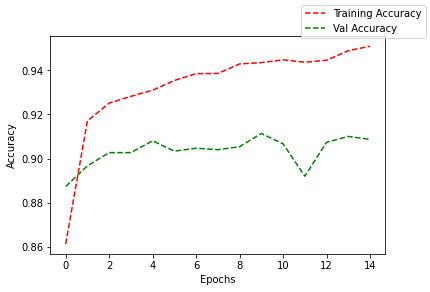

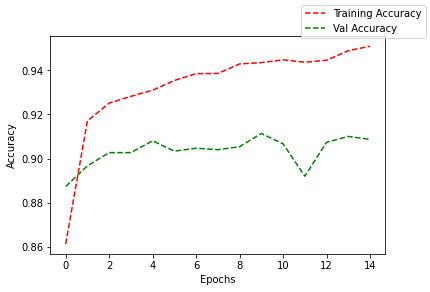

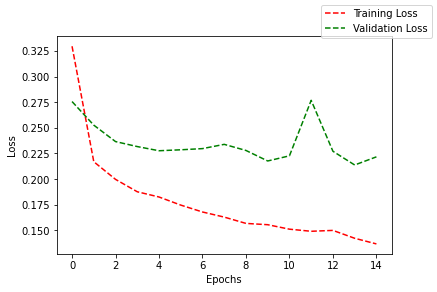

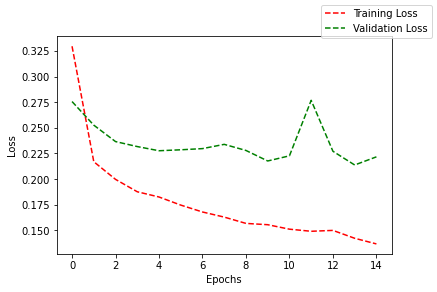

In [0]:
model_trained = train_model(model, criterion, optimizer, num_epochs=15)

### 5. Save and load the model

In [0]:
torch.save(model_trained.state_dict(), './gdrive/My Drive/Assign 5/VGG_multiple_conv_layers.h5')

In [0]:
model = models.vgg16(pretrained=True).to(device)
num_features = model.classifier[0].in_features
model.classifier=nn.Sequential( nn.Linear(num_features,160),
                              nn.Sigmoid(),
                               nn.Linear(160,2)).to(device)
model.load_state_dict(torch.load('./gdrive/My Drive/Assign 5/VGG_multiple_conv_layers.h5'))
print('testing')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



testing


### 6. Make predictions on sample test images

In [0]:
import torchvision 
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, batch_size=9, shuffle=True)

class_names = test_data.classes
print(class_names)


['infected', 'normal']


In [0]:
len(test_data)

1500

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


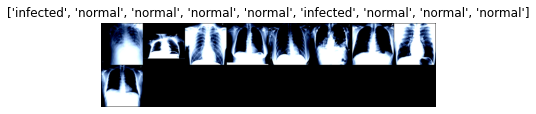

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal normal normal infected normal normal normal
Ground Truth:  infected normal normal normal normal infected normal normal normal


In [0]:
def Test_Result(testloader):
  correct = 0
  total = 0
  TN = 0
  FN=0
  TP=0
  FP=0
  print(device)
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          #print('\r', labels,end='')
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          gt=labels.to('cpu').numpy()
          est= predicted.to('cpu').numpy()
          #print(gt)
          for a in range(len(gt)):
            if gt[a]==0 and est[a]==0:
              TP+=1
            elif gt[a]==0 and est[a]==1:
              FP+=1
            elif gt[a]==1 and est[a]==0:
              FN+=1
            else :
              TN+=1
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))
  print('   True Positive ',TP,'   False Positive ',FP,'\n   True Negative ',TN,'   False Negative ',FN)
  print('F1 score : ',(2*TP)/(2*TP+FP+FN))

In [0]:
Test_Result(testloader)


cuda:0
Accuracy of the network: 97 %
   True Positive  591    False Positive  24 
   True Negative  864    False Negative  21
F1 score :  0.9633251833740831


In [0]:
Test_Result(dataloaders['validation'])

cuda:0
Accuracy of the network: 90 %
   True Positive  549    False Positive  66 
   True Negative  814    False Negative  71
F1 score :  0.8890688259109312


In [0]:
Test_Result(dataloaders['train'])

cuda:0
Accuracy of the network: 95 %
   True Positive  4580    False Positive  339 
   True Negative  6842    False Negative  239
F1 score :  0.9406448962826043


### ResNet Entire Model

In [0]:
from google.colab import drive
drive.mount('./gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [0]:
#!unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip" -d "./gdrive/My Drive"

In [0]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-1.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [0]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [0]:
torch.__version__

'1.4.0'

In [0]:
data_dir_tr = "./gdrive/My Drive/Assign_5_Augm/train_aug"
data_dir_vl = "./gdrive/My Drive/Assignment 5 Dataset"

### 2. Create PyTorch data generators

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir_vl+'/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(data_dir_vl+'/validation', data_transforms['validation'])
}
print(image_datasets['train'].class_to_idx)

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=64,
                                shuffle=True,num_workers=4),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=64,
                                shuffle=False,num_workers=4)
}
len(image_datasets['train'])
#len(image_datasets['validation'])

{'infected': 0, 'normal': 1}


12000

### 3. Create the network

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
model = models.resnet18(pretrained=True).to(device)
print(model)
num_features = model.fc.in_features

model.fc=nn.Sequential( nn.Linear(num_features,160),
                               nn.Sigmoid(),
                               nn.Linear(160,2)).to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.fc.parameters(),lr=0.001, momentum=0.9)
for param in filter(lambda p: p.requires_grad, model.parameters()):
  print(param.requires_grad)
optimizer = optim.Adam(model.parameters(),lr=0.001)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


### 4. Train the model

In [0]:

def train_model(model, criterion, optimizer, num_epochs=3):
    loss_train=[]
    loss_val=[]
    acc_train=[]
    acc_val=[]
    Epochs=[]
    for epoch in range(num_epochs):
        print('Epoch ' ,epoch+1,'/',num_epochs)
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            i=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                i=i+1
                print('\r',i,end="")

                #print(i)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])
            if phase == 'train':
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            else:
                acc_val.append(epoch_acc)
                loss_val.append(epoch_loss)
                
            #Epochs,append(epoch_acc)

            print('  ','{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    
    A=plt.figure(1)
    #plt.plot(it,Loss,label='CE')
    plt.plot(range(num_epochs),acc_train,'r--',label='Training Accuracy')
    plt.plot(range(num_epochs),acc_val,'g--',label='Val Accuracy')
    #print(Loss)
    A.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    g = plt.figure(2)
    plt.plot(range(num_epochs),loss_train,'r--',label='Training Loss')
    plt.plot(range(num_epochs),loss_val,'g--',label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    g.legend()
    #g.savefig(('LOss'.png'),dpi=1200)        
    return model


In [0]:
len(image_datasets['train'])

12000

[link text](https://)

Epoch  1 / 15
----------
 188   train loss: 0.2649, acc: 0.8960
 24   validation loss: 0.2658, acc: 0.9000
Epoch  2 / 15
----------
 188   train loss: 0.2127, acc: 0.9182
 24   validation loss: 0.2535, acc: 0.9007
Epoch  3 / 15
----------
 188   train loss: 0.1962, acc: 0.9242
 24   validation loss: 0.2550, acc: 0.9027
Epoch  4 / 15
----------
 188   train loss: 0.1904, acc: 0.9299
 24   validation loss: 0.2652, acc: 0.8900
Epoch  5 / 15
----------
 188   train loss: 0.1803, acc: 0.9321
 24   validation loss: 0.2565, acc: 0.8953
Epoch  6 / 15
----------
 188   train loss: 0.1765, acc: 0.9343
 24   validation loss: 0.4087, acc: 0.8560
Epoch  7 / 15
----------
 188   train loss: 0.1678, acc: 0.9372
 24   validation loss: 0.2669, acc: 0.9040
Epoch  8 / 15
----------
 188   train loss: 0.1680, acc: 0.9363
 24   validation loss: 0.2220, acc: 0.9127
Epoch  9 / 15
----------
 188   train loss: 0.1633, acc: 0.9373
 24   validation loss: 0.2592, acc: 0.8987
Epoch  10 / 15
----------
 188   trai

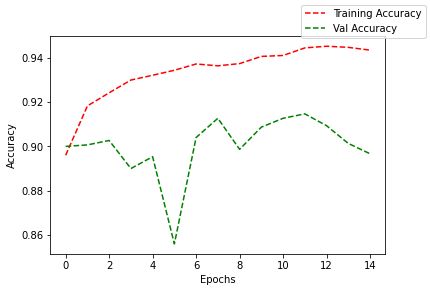

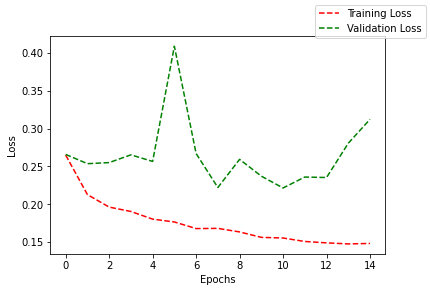

In [0]:
model_trained = train_model(model, criterion, optimizer, num_epochs=15)

### 5. Save and load the model

In [0]:
torch.save(model_trained.state_dict(), './gdrive/My Drive/Assign 5/res18_entire.h5')

In [0]:
model = models.resnet18(pretrained=True).to(device)
num_features = model.fc.in_features
model.fc=nn.Sequential( nn.Linear(num_features,160),
                               nn.Sigmoid(),
                               nn.Linear(160,2)).to(device)
model.load_state_dict(torch.load('./gdrive/My Drive/Assign 5/res18_entire.h5'))
model.eval()
print('testing')

testing


### 6. Make predictions on sample test images

In [0]:

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_data = datasets.ImageFolder(data_dir_vl + '/test', transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, batch_size=9, shuffle=True)

class_names = test_data.classes
print(class_names)


['infected', 'normal']


In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


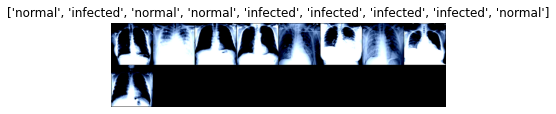

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected normal normal infected infected infected normal normal
Ground Truth:  normal infected normal normal infected infected infected infected normal


In [0]:
def Test_Result(testloader):
  correct = 0
  total = 0
  TN = 0
  FN=0
  TP=0
  FP=0
  print(device)
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          #print('\r', labels,end='')
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          gt=labels.to('cpu').numpy()
          est= predicted.to('cpu').numpy()
          #print(gt)
          for a in range(len(gt)):
            if gt[a]==0 and est[a]==0:
              TP+=1
            elif gt[a]==0 and est[a]==1:
              FP+=1
            elif gt[a]==1 and est[a]==0:
              FN+=1
            else :
              TN+=1
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))
  print('   True Positive ',TP,'   False Positive ',FP,'\n   True Negative ',TN,'   False Negative ',FN)
  print('F1 score : ',(2*TP)/(2*TP+FP+FN))

In [0]:
Test_Result(testloader)

cuda:0
Accuracy of the network: 95 %
   True Positive  548    False Positive  67 
   True Negative  883    False Negative  2
F1 score :  0.940878201634877


In [0]:
Test_Result(dataloaders['validation'])

In [0]:
# They were deleted accidentially can I am writing manaully
#Validation Dataset
#Accuracy of the network: 89 %
#   True Positive  476    False Positive  139 
#   True Negative  869    False Negative  16
#F1 score :  0.8601200000


In [0]:
Test_Result(dataloaders['train'])

cuda:0
Accuracy of the network: 94 %
   True Positive  4301    False Positive  618 
   True Negative  6984    False Negative  97
F1 score :  0.923542293809167


### VGG Entire

In [2]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [0]:
#!unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip" -d "./gdrive/My Drive"

In [4]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

     |████████████████████████████████| 512.6MB 1.2MB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.60 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
     |████████████████████████████████| 753.4MB 16kB/s 
  Found existing installation: torch 0.4.1
    Uninstalling torch-0.4.1:
      Successfully uninstalled torch-0.4.1


In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [5]:
torch.__version__

'1.4.0'

In [0]:
data_dir = "./gdrive/My Drive/Assignment 5 Dataset"
data_dir_tr = "./gdrive/My Drive/Assign_5_Augm/train_aug"


### 2. Create PyTorch data generators

In [9]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir+'/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(data_dir+'/validation', data_transforms['validation'])
}
print(image_datasets['train'].class_to_idx)

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=64,
                                shuffle=True,num_workers=0),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=64,
                                shuffle=False,num_workers=0)
}
len(image_datasets['train'])
#len(image_datasets['validation'])

{'infected': 0, 'normal': 1}


12000

### 3. Create the network

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
model = models.vgg16(pretrained=True).to(device)

In [15]:
num_features = model.classifier[0].in_features
for param in model.parameters():
  param.requires_grad=True
#for param in model.features[28].parameters():
  #param.requires_grad=True
model.classifier=nn.Sequential( nn.Linear(num_features,160),
                                nn.Sigmoid(),
                               nn.Linear(160,2)).to(device)
#print(model)
#total_params = sum(p.numel() for p in model.parameters())
#print(total_params)
for param in model.parameters():
  print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [16]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.fc.parameters(),lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.0001)

### 4. Train the model

In [0]:

def train_model(model, criterion, optimizer, num_epochs=3):
    loss_train=[]
    loss_val=[]
    acc_train=[]
    acc_val=[]
    Epochs=[]
    for epoch in range(num_epochs):
        print('Epoch ' ,epoch+1,'/',num_epochs)
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            i=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                i=i+1
                print('\r',i,end="")

                #print(i)
                #print(i)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])
            if phase == 'train':
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            else:
                acc_val.append(epoch_acc)
                loss_val.append(epoch_loss)
                
            #Epochs,append(epoch_acc)

            print('  ','{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    
    A=plt.figure(1)
    #plt.plot(it,Loss,label='CE')
    plt.plot(range(num_epochs),acc_train,'r--',label='Training Accuracy')
    plt.plot(range(num_epochs),acc_val,'g--',label='Val Accuracy')
    #print(Loss)
    A.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    g = plt.figure(2)
    plt.plot(range(num_epochs),loss_train,'r--',label='Training Loss')
    plt.plot(range(num_epochs),loss_val,'g--',label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    g.legend()
    #g.savefig(('LOss'.png'),dpi=1200)        
    return model


In [19]:
len(image_datasets['train'])

12000

Epoch  1 / 15
----------
 188   train loss: 0.1734, acc: 0.9348
 24   validation loss: 0.2006, acc: 0.9253
Epoch  2 / 15
----------
 188   train loss: 0.1558, acc: 0.9412
 24   validation loss: 0.2457, acc: 0.9140
Epoch  3 / 15
----------
 188   train loss: 0.1597, acc: 0.9413
 24   validation loss: 0.1951, acc: 0.9233
Epoch  4 / 15
----------
 188   train loss: 0.1422, acc: 0.9484
 24   validation loss: 0.2336, acc: 0.9133
Epoch  5 / 15
----------
 188   train loss: 0.1415, acc: 0.9503
 24   validation loss: 0.1950, acc: 0.9200
Epoch  6 / 15
----------
 188   train loss: 0.1267, acc: 0.9570
 24   validation loss: 0.1967, acc: 0.9267
Epoch  7 / 15
----------
 188   train loss: 0.1163, acc: 0.9582
 24   validation loss: 0.2327, acc: 0.9020
Epoch  8 / 15
----------
 188   train loss: 0.1105, acc: 0.9617
 24   validation loss: 0.1980, acc: 0.9267
Epoch  9 / 15
----------
 188   train loss: 0.1049, acc: 0.9619
 24   validation loss: 0.1879, acc: 0.9287
Epoch  10 / 15
----------
 188   trai

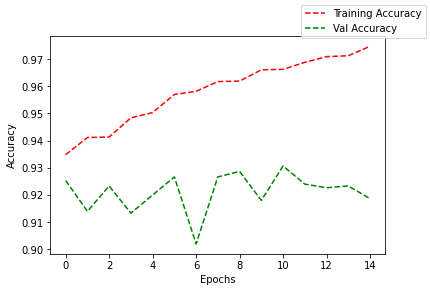

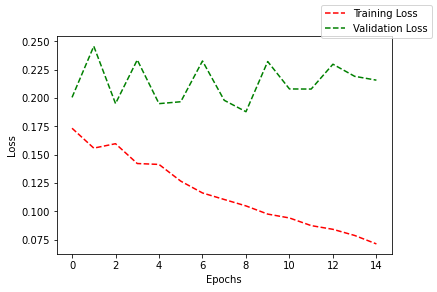

In [22]:
model_trained = train_model(model, criterion, optimizer, num_epochs=15)

### 5. Save and load the model

In [0]:
torch.save(model_trained.state_dict(), './gdrive/My Drive/Assign 5/‘vgg16_entire.h5')

In [13]:
model = models.vgg16(pretrained=True).to(device)
num_features = model.classifier[0].in_features
model.classifier=nn.Sequential( nn.Linear(num_features,160),
                                nn.Sigmoid(),
                               nn.Linear(160,2)).to(device)
model.load_state_dict(torch.load('./gdrive/My Drive/Assign 5/‘vgg16_entire.h5'))
print('testing')

testing


### 6. Make predictions on sample test images

In [14]:
import torchvision 
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, batch_size=9, shuffle=True)

class_names = test_data.classes
print(class_names)


['infected', 'normal']


In [15]:
len(test_data)

1500

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


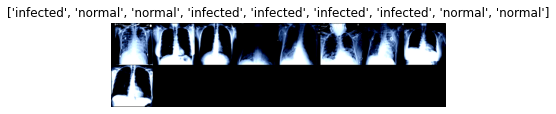

In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [18]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal normal infected infected infected infected normal normal
Ground Truth:  infected normal normal infected infected infected infected normal normal


In [0]:
def Test_Result(testloader):
  correct = 0
  total = 0
  TN = 0
  FN=0
  TP=0
  FP=0
  print(device)
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          #print('\r', labels,end='')
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          gt=labels.to('cpu').numpy()
          est= predicted.to('cpu').numpy()
          #print(gt)
          for a in range(len(gt)):
            if gt[a]==0 and est[a]==0:
              TP+=1
            elif gt[a]==0 and est[a]==1:
              FP+=1
            elif gt[a]==1 and est[a]==0:
              FN+=1
            else :
              TN+=1
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))
  print('   True Positive ',TP,'   False Positive ',FP,'\n   True Negative ',TN,'   False Negative ',FN)
  print('F1 score : ',(2*TP)/(2*TP+FP+FN))

In [24]:
Test_Result(testloader)


cuda:0
Accuracy of the network: 96 %
   True Positive  595    False Positive  20 
   True Negative  859    False Negative  26
F1 score :  0.9627831715210357


In [25]:
Test_Result(dataloaders['validation'])

cuda:0
Accuracy of the network: 91 %
   True Positive  543    False Positive  72 
   True Negative  835    False Negative  50
F1 score :  0.8990066225165563


In [27]:
Test_Result(dataloaders['train'])

cuda:0
Accuracy of the network: 97 %
   True Positive  4728    False Positive  191 
   True Negative  7024    False Negative  57
F1 score :  0.9744435284418796
